In [1]:
import time
import pandas as pd
import numpy as np
from collections import Counter
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import copy
import seaborn as sns
import pylab as pl
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.metrics import classification_report, accuracy_score
from subprocess import check_call
from IPython.display import Image
from sklearn.tree import export_graphviz
import operator
from dtreeviz.trees import *

ModuleNotFoundError: No module named 'pandas'

### Install dependencies

In [2]:
# !pip install pandas
# !pip install seaborn
# !pip install sklearn
# !pip install scikit-plot
# !pip install dtreeviz

### Certificate Of Authenticity
<b>Author:</b> Eric Cacciavillani
<br>
<b>Class:</b> DAT-330-01
<br>
<b>Date:</b> January 24, 2019
<br>
<b>Certification of Authenticity: </b>
<br>
 I certify that this is entirely my own work,
 except where I have given fully documented
 references to the work of others.
 I understand the definition and consequences of
 plagiarism and acknowledge that the assessor of this assignment may,
 for the purpose of assessing this assignment reproduce this assignment
 and provide a copy to another member of academic staff and / or communicate
 a copy of this assignment to a plagiarism checking service(which may then
 retain a copy of this assignment on its database for the purpose
 of future plagiarism checking).

### Define functions to use for later use

In [3]:
def cluster_count(clust):
    """
        Returns back dataframe of clustername to the count
    """
    cluster_count_df = pd.DataFrame(columns=['Cluster_Name', "Cluster_Count"])

    for cluster, count in Counter(clust.labels_).items():
        cluster_count_df = cluster_count_df.append({'Cluster_Name': cluster,
                                                    'Cluster_Count': count},
                                                   ignore_index=True)
    return cluster_count_df.sort_values(by=[
        'Cluster_Name']).reset_index(drop=True)


def find_nearest(numbers, target):
    """
        Find the closest fitting number to the target number
    """
    numbers = np.asarray(numbers)
    idx = (np.abs(numbers - target)).argmin()
    return numbers[idx]


def encode_decode_df(passed_df,
                     encoder_decoder_map):
    """
        Uses a hash map to decode dataframe data
    """

    def encode_decode_col(data, decoder):
        return decoder[data]

    df = copy.deepcopy(passed_df)
    for col in df.columns:
        if col in encoder_decoder_map.keys():
            df[col] = np.vectorize(encode_decode_col)(
                df[col], encoder_decoder_map[col])

    return df


def remove_outliers_df(df, removal_dict):
    """
        Removes outliers with a 'High'/'Low' keyed map
    """

    df = copy.deepcopy(df)

    for feature_name in df.columns:

        # Replacements needed
        if feature_name in removal_dict.keys():
            if removal_dict[feature_name]["High"]:
                df = df[df[feature_name] < removal_dict[feature_name]["High"]]
            elif removal_dict[feature_name]["Low"]:
                df = df[df[feature_name] > removal_dict[feature_name]["Low"]]

    return df.reset_index(drop=True)


def inspect_feature_matrix(matrix,
                           feature_names):
    """
        Creates a dataframe to quickly analyze a matrix
    """
    mean_matrix = np.mean(matrix, axis=0)
    std_matrix = np.std(matrix, axis=0)
    data_dict = dict()
    for index, feature_name in enumerate(feature_names):
        data_dict[feature_name] = [mean_matrix[index],
                                   std_matrix[index]]

    return pd.DataFrame.from_dict(data_dict,
                                  orient='index',
                                  columns=['Mean',
                                           'Standard Dev'])


def display_rank_graph(feature_names, metric,
                       title="", y_title="", x_title=""):
    """
        Darker colors have higher rankings (values)
    """
    plt.figure(figsize=(7, 7))

    # Init color ranking fo plot
    # Ref: http://tinyurl.com/ydgjtmty
    pal = sns.color_palette("GnBu_d", len(metric))
    rank = np.array(metric).argsort().argsort()
    ax = sns.barplot(y=feature_names, x=metric,
                     palette=np.array(pal[::-1])[rank])
    plt.xticks(rotation=0, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(x_title, fontsize=20, labelpad=20)
    plt.ylabel(y_title, fontsize=20, labelpad=20)
    plt.title(title, fontsize=15)
    plt.show()
    plt.close()


# General purpose model optimizer
def optimize_model_grid(model,
                        X_train,
                        y_train,
                        param_grid,
                        cv=10):

    # Instantiate the GridSearchCV object: logreg_cv
    model_cv = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1)

    # Fit it to the data
    model_cv.fit(X_train, y_train)

    # Print the tuned parameters and score
    print("Tuned Parameters: {}".format(model_cv.best_params_))
    print("Best score on trained data was {0:4f}".format(model_cv.best_score_))

    model = type(model)(**model_cv.best_params_)

    return model_cv.best_params_


# Not created by me!
# Author: https://github.com/scikit-learn/scikit-learn/issues/7845
def report_to_dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)

    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return D_class_data


def create_decorrelate_df(df,
                          df_features,
                          target_name,
                          desired_col_average=0.5,
                          show=True):

    df = copy.deepcopy(df)
    df_features = copy.deepcopy(df_features)
    while True:

        # Display correlation map
        corr_metrics = df.corr()
        if show:
            display(corr_metrics.style.background_gradient())

        # Get the correlation means of each feature
        corr_feature_means = []
        for feature_name in list(corr_metrics.columns):

            # Ignore target feature; Only a problem if target was numerical
            if target_name != feature_name:
                corr_feature_means.append(corr_metrics[feature_name].mean())

        if show:
            # Graph rank
            display_rank_graph(feature_names=list(corr_metrics.columns),
                               metric=corr_feature_means,
                               title="Average Feature Correlation",
                               y_title="Correlation Average",
                               x_title="Features")

        index, max_val = get_max_index_val(corr_feature_means)

        if max_val > desired_col_average:
            # Drop col and notify
            feature_name = list(corr_metrics.columns)[index]
            df.drop(feature_name, axis=1, inplace=True)
            df_features.remove(feature_name)
            print("Dropped column: {0}".format(feature_name))
            vertical_spacing(5)

        # End loop desired average reached
        else:
            if show:
                display(corr_feature_means)
            break

    return df, df_features


def get_max_index_val(given_list):
    """
        Returns the max index and value of a list
    """
    return max(enumerate(given_list), key=operator.itemgetter(1))


def visualize_clusters(model, scaled_data, model_name=""):
    """
        Creates visualization of clustering model on given data.
    """
    markers = ["+", "*", ".", "o", "v", "P", "H", "X"]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', '#007BA7', '#ff69b4']
    # Display ranking on color based on amount data points per cluster
    unique, counts = np.unique(model.labels_, return_counts=True)
    cluster_names = ["Cluster:" + str(cluster_label)
                     for cluster_label in unique]
    display_rank_graph(feature_names=cluster_names,
                       metric=counts,
                       title=model_name,
                       y_title="Clusters",
                       x_title="Found per cluster")
    vertical_spacing(2)

    # Display clustered graph
    cluster_array = list(range(0, len(cluster_names)))
    scaled_cluster_label = np.hstack(
        (scaled_data, np.reshape(
            model.labels_.astype(int), (scaled_data.shape[0], 1))))
    for i in range(0, scaled_cluster_label.shape[0]):
        cluster_label = int(scaled_cluster_label[i][-1])
        cluster_array[cluster_label] = pl.scatter(
            scaled_cluster_label[i, 0], scaled_cluster_label[i, 1],
            c=colors[cluster_label], marker=str(markers[cluster_label]))

    pl.legend(cluster_array, cluster_names)
    pl.title(model_name + ' visualized with data', fontsize=15)
    pl.show()
    pl.close()
    plt.close()


def create_cluster_sub_dfs(df, model, numerical_features):
    # Dataframe to analyze model 'better' choices
    shrunken_full_df = df.drop('Cluster_Name', axis=1).drop(df.index)

    # Store each sub-dataframe based on cluster label
    clustered_dataframes = dict()

    for cluster_label in set(model.labels_):
        cluster_df = df[df["Cluster_Name"] == cluster_label]
        # Ignore cluster with only one patient
        if len(cluster_df) <= 1:
            continue
        # ---
        zscore_cluster_df = cluster_df.drop(
            'Cluster_Name', axis=1).apply(zscore)

        # Check if cluster is only comprised of one data point
        if cluster_df.shape[0] > 1:

            # Iterate through all numerical features
            for numerical_feature in numerical_features:

                nan_check = zscore_cluster_df[
                    numerical_feature].isnull().values.any()
                # Check for nans
                if not nan_check:

                    zscore_cluster_df = zscore_cluster_df[
                        zscore_cluster_df[numerical_feature] >= -2]
                    zscore_cluster_df = zscore_cluster_df[
                        zscore_cluster_df[numerical_feature] <= 2]

        # Dummy list of -1s alloc at given pos of 'zscore_cluster_df' indexs
        reshaped_index = [-1] * len(df.index.values)

        for given_index in list(zscore_cluster_df.index.values):
            reshaped_index[given_index] = given_index

        # Pass back all vectors that passed the zscore test
        bool_array = pd.Series(reshaped_index).astype(int) == pd.Series(
            list(df.index.values)).astype(int)

        temp_cluster_df = df[bool_array].reset_index(drop=True)

        # Store in proper collection objs
        shrunken_full_df = shrunken_full_df.append(temp_cluster_df)

        clustered_dataframes[
            "Cluster:" + str(cluster_label)] = temp_cluster_df.drop(
            'Cluster_Name', axis=1)

    return clustered_dataframes, shrunken_full_df


def create_cluster_profiles(clustered_dataframes,
                            shrunken_df,
                            numerical_features,
                            show=True):
    cluster_profiles_df = pd.DataFrame(columns=shrunken_df.columns).drop(
        'Cluster_Name', axis=1)
    rows_count = 0
    for cluster_identfier, cluster_dataframe in clustered_dataframes.items():
        df = pd.DataFrame(columns=cluster_dataframe.columns)
        df = df.append(cluster_dataframe.mean(), ignore_index=True)
        df.index = [cluster_identfier]

        # Attempt to convert numbers found within the full set of data
        for col in cluster_dataframe.columns:
            if col not in numerical_features:
                df[col] = find_nearest(numbers=shrunken_df[
                    col].value_counts().index.tolist(),
                    target=df[col].values[0])

        # Evaluate cluster dataframe by dataframe
        eval_df = pd.DataFrame(columns=cluster_dataframe.columns)
        eval_df = eval_df.append(cluster_dataframe.mean(), ignore_index=True)
        eval_df = eval_df.append(cluster_dataframe.min(), ignore_index=True)
        eval_df = eval_df.append(cluster_dataframe.median(), ignore_index=True)
        eval_df = eval_df.append(cluster_dataframe.max(), ignore_index=True)
        eval_df = eval_df.append(cluster_dataframe.std(), ignore_index=True)
        eval_df = eval_df.append(cluster_dataframe.var(), ignore_index=True)
        eval_df.index = ["Mean", "Min", "Median",
                         "Max", "Standard Deviation", "Variance"]

        if show:
            print("Total found in {0} is {1}".format(
                cluster_identfier, cluster_dataframe.shape[0]))
            display(df)
            display(eval_df)
            vertical_spacing(7)

        cluster_profiles_df = cluster_profiles_df.append(
            encode_decode_df(passed_df=df,
                             encoder_decoder_map=master_decoder))

        rows_count += cluster_dataframe.shape[0]
    # End clusters loop

    if show:
        print("Total points in all shrunken clusters: ", rows_count)

    return cluster_profiles_df


def guess_species_label(df):
    """
        Made for fun/lols
    """

    species_values = list(df["species"].values)
    cluster_values = list(df["Cluster_Name"].values)

    guess_cluster_species = dict()
    for species_val in species_values:
        species_string = master_decoder["species"][species_val]

        max_val = float("-inf")
        for cluster_val in cluster_values:
            new_val = df[(df.species == species_val) &
                         (df.Cluster_Name == cluster_val)].shape[0]

            if new_val > max_val:
                max_val = new_val
                guess_cluster_species[species_string] = (cluster_val, max_val)

    return guess_cluster_species


# I am this lazy yes...
def vertical_spacing(spaces=1):
    for _ in range(0, spaces):
        print()


# Using past pythons enums
def enum(**enums):
    return type('Enum', (), enums)

### Simple model to help track feature changes

In [4]:
class DataFrameFeatureTypesHolder:

    """
        Seperates the features based off of dtypes
        to better keep track of feature changes over time.
        Should only be used for manipulation of features.
    """

    def __init__(self,
                 categorical_features,
                 integer_features,
                 float_features):

        self.__categorical_features = categorical_features
        self.__numerical_features = integer_features | float_features
        self.__integer_features = integer_features
        self.__float_features = float_features

    # ---Getters/Appenders

    # Numerical
    def numerical_features(self):
        return list(self.__numerical_features)

    def integer_features(self):
        return list(self.__integer_features)

    def append_integer_features(self,
                                feature_name):
        self.__integer_features |= set(feature_name)
        self.__numerical_features |= set(feature_name)

    def float_features(self):
        return list(self.__float_features)

    def append_float_features(self,
                              feature_name):
        self.__float_features |= set(feature_name)
        self.__numerical_features |= set(feature_name)

    # Categorical
    def categorical_features(self):
        return list(self.__categorical_features)

    def append_categorical_features(self):
        self.__categorical_features |= set(feature_name)

    # ---Remover
    def remove(self,
               feature_name):
        try:
            self.__categorical_features.remove(feature_name)
        except KeyError:
            pass

        try:
            self.__numerical_features.remove(feature_name)
        except KeyError:
            pass

        try:
            self.__integer_features.remove(feature_name)
        except KeyError:
            pass

        try:
            self.__float_features.remove(feature_name)
        except KeyError:
            pass

    def display_all(self):
        print("Categorical Features: {0}\n".format(
            self.__categorical_features))
        print("Numerical Features: {0}\n".format(
            self.__numerical_features))
        print("Integer Features: {0}\n".format(
            self.__integer_features))
        print("Float Features: {0}\n".format(
            self.__float_features))

## 1.) Import and analyze dataset

In [5]:
iris = load_iris()

# import some data to play with
iris_df = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                       columns=iris['feature_names'] + ['species'])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [6]:
# Encoding scheme for species; 0=Setosa , 1=Versicolor, 2=Virginica
display(iris.target_names)

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [7]:
# http://archive.ics.uci.edu/ml/datasets/Heart+Disease
master_encoder = dict()
master_decoder = dict()

master_encoder["species"] = {"Setosa": 0,
                             "Versicolor": 1,
                             "Virginica": 2}
master_decoder["species"] = {v: k for k,
                             v in master_encoder["species"].items()}

### Define features as categorical/numerical by hand

In [8]:
target_name = "species"

In [9]:
df_features = DataFrameFeatureTypesHolder(categorical_features=set({
    "species"}),
                                          integer_features=set({}),
                                          float_features=set(
                                              {"sepal length (cm)",
                                               "sepal width (cm)",
                                               "petal length (cm)",
                                               "petal width (cm)"}))
df_features.display_all()

Categorical Features: {'species'}

Numerical Features: {'sepal length (cm)', 'sepal width (cm)', 'petal width (cm)', 'petal length (cm)'}

Integer Features: set()

Float Features: {'sepal length (cm)', 'sepal width (cm)', 'petal width (cm)', 'petal length (cm)'}



## 2.) Basic Data Cleaning and Decode

### Look at data types of each feature

In [10]:
iris_df.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
species              float64
dtype: object

In [11]:
iris_df.isna().any()

sepal length (cm)    False
sepal width (cm)     False
petal length (cm)    False
petal width (cm)     False
species              False
dtype: bool

### Decode the data

In [12]:
iris_df = encode_decode_df(passed_df=iris_df,
                           encoder_decoder_map=master_decoder)
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


## 3.) Analyze data

### Inspect at correlate matrix

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1,-0.11757,0.871754,0.817941
sepal width (cm),-0.11757,1,-0.42844,-0.366126
petal length (cm),0.871754,-0.42844,1,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1


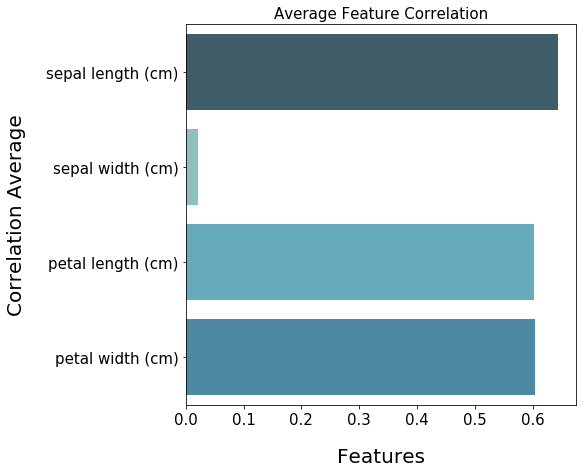

In [13]:
corr_metrics = iris_df.corr()
display(corr_metrics.style.background_gradient())

# Get the correlation means of each feature
corr_feature_means = []
for feature_name in list(corr_metrics.columns):
    corr_feature_means.append(corr_metrics[feature_name].mean())

# Graph rank
display_rank_graph(feature_names=list(corr_metrics.columns),
                   metric=corr_feature_means,
                   title="Average Feature Correlation",
                   y_title="Correlation Average",
                   x_title="Features")

<p>&emsp; Very high correlation with one another </p>

### Plot data

/Users/ericcacciavillani/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


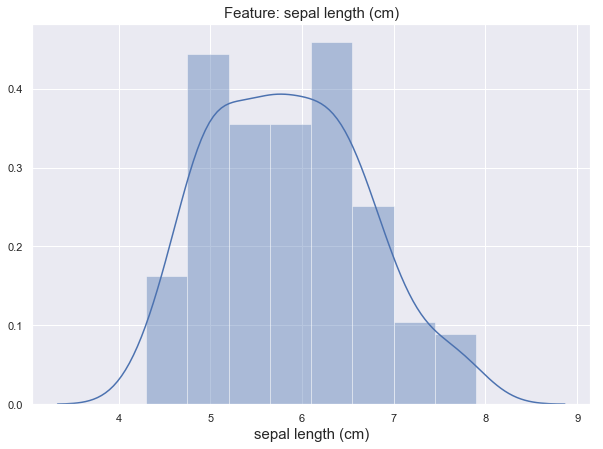

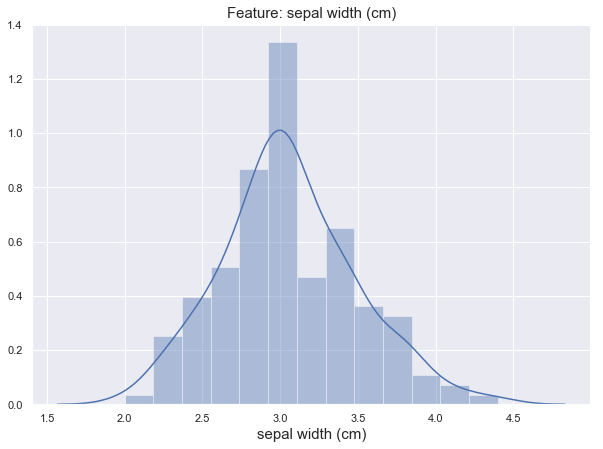

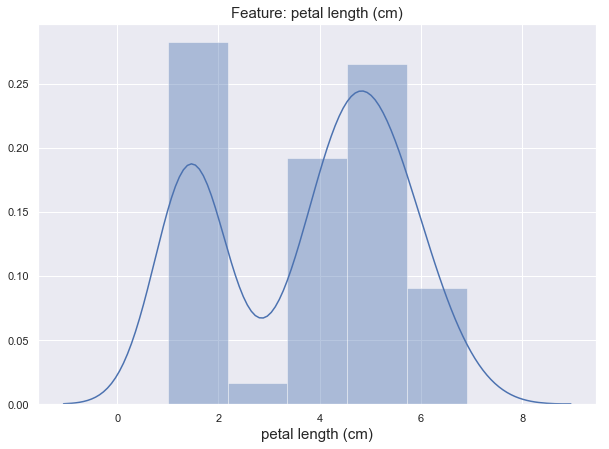

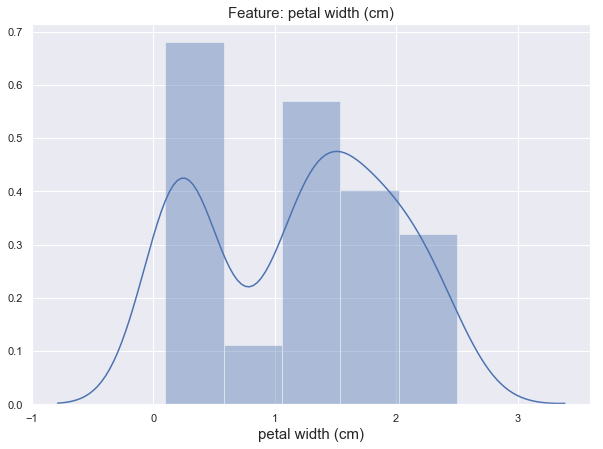

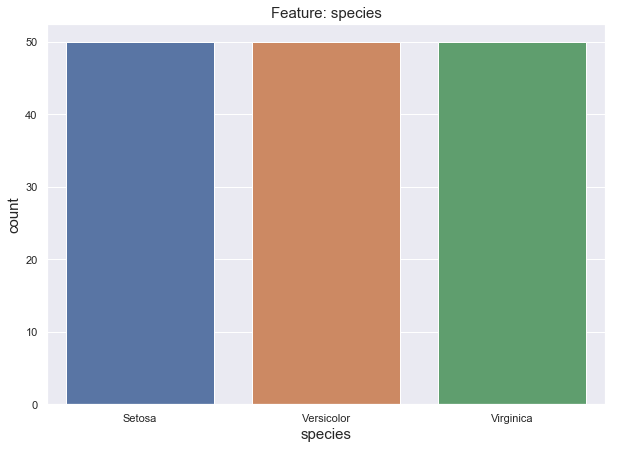

In [14]:
sns.set(style="darkgrid")
sns.set_palette("muted")
sns.set(rc={'figure.figsize': (10, 7)})

for feature_name in iris_df.columns:

    plt.title("Feature: " + feature_name,
              fontsize=15)
    if feature_name not in df_features.numerical_features():
        plt.ylabel("count", fontsize=15)
        sns.countplot(iris_df[feature_name])
    else:
        sns.distplot(iris_df[feature_name])

    plt.xlabel(feature_name, fontsize=15)
    plt.show()
    plt.close()
    vertical_spacing(3)

### Quick General Analsysis
<b>Numerical features</b>: <p>&emsp; If they contain the same type before
    measuring the distribution is very similar.</p>
<b>species</b>: <p>&emsp; Distribution
    is exactly the same for each species.</p>

### Attempt to center out numerical data

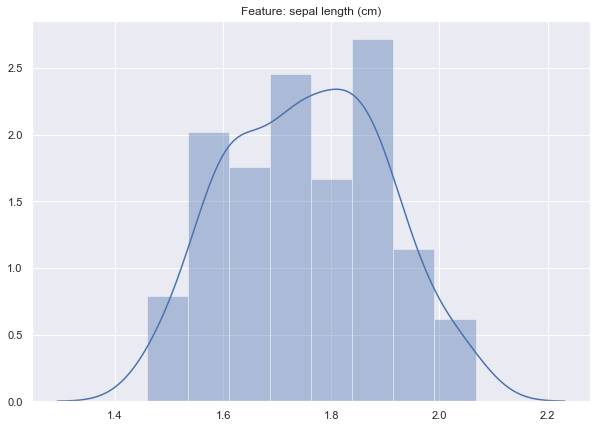

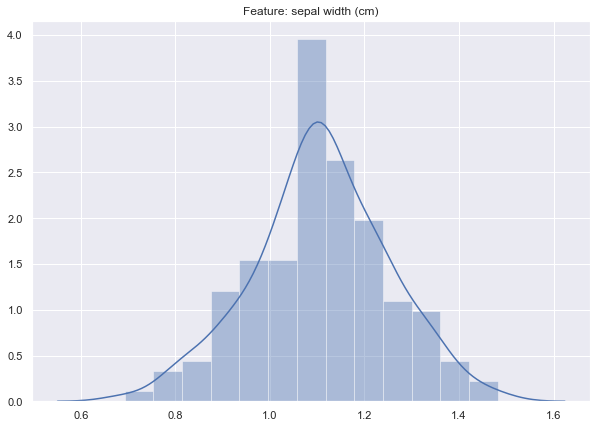

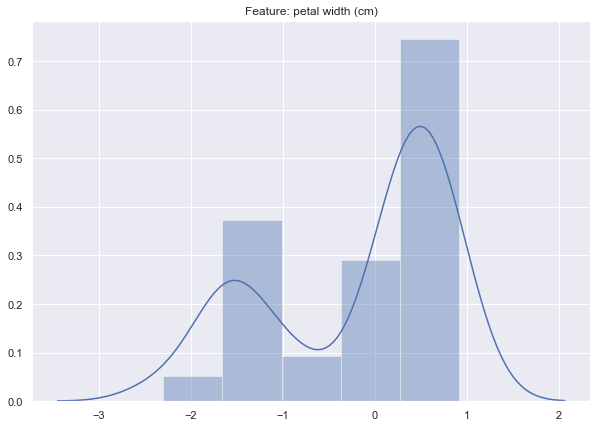

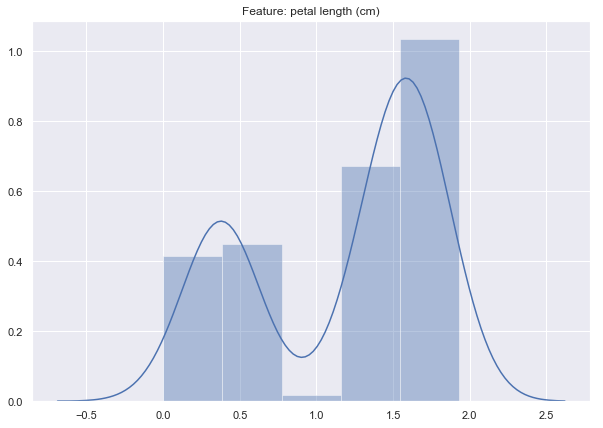

In [15]:
for feature_name in df_features.numerical_features():

    positive_only_vector = np.where(iris_df[feature_name] < 1e-5,
                                    1e-8, iris_df[feature_name])

    plt.title("Feature: " + feature_name)
    sns.distplot(np.log(positive_only_vector))
    plt.show()
    plt.close()

## 4.) Data transformation

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1,-0.11757,0.871754,0.817941
sepal width (cm),-0.11757,1,-0.42844,-0.366126
petal length (cm),0.871754,-0.42844,1,0.962865
petal width (cm),0.817941,-0.366126,0.962865,1


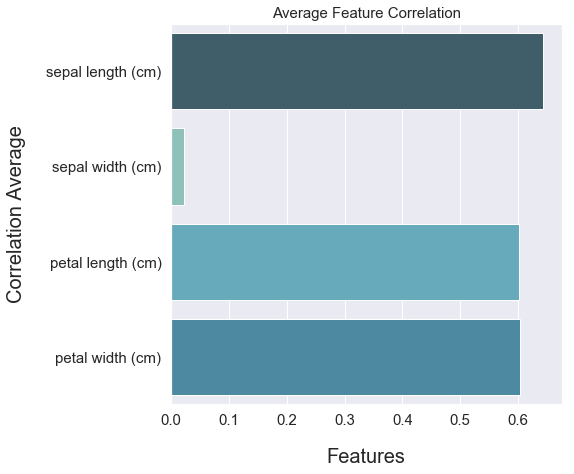

Dropped column: sepal length (cm)







,sepal width (cm),petal length (cm),petal width (cm)
sepal width (cm),1,-0.42844,-0.366126
petal length (cm),-0.42844,1,0.962865
petal width (cm),-0.366126,0.962865,1


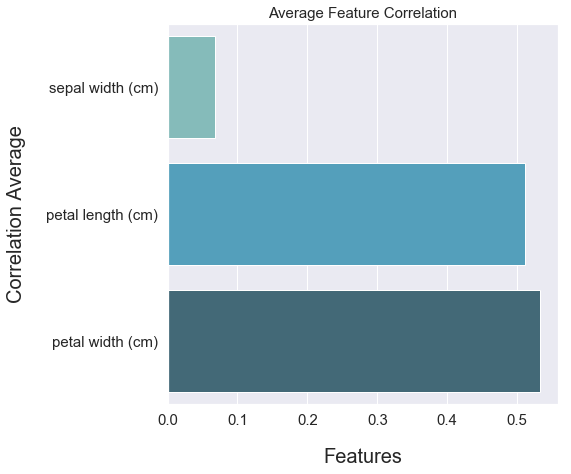

Dropped column: petal width (cm)







,sepal width (cm),petal length (cm)
sepal width (cm),1,-0.42844
petal length (cm),-0.42844,1


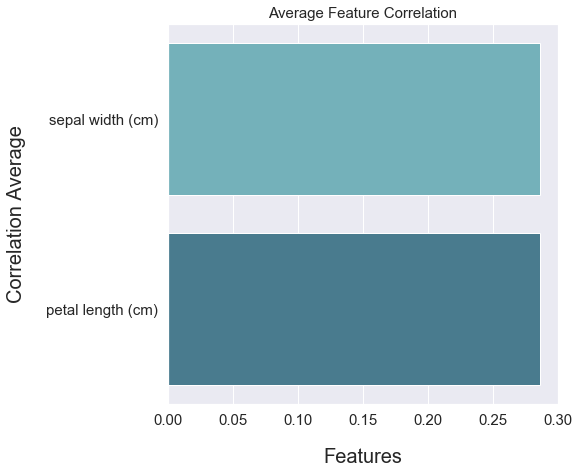

[0.28577994783473, 0.28577994783473]

In [16]:
iris_df, df_features = create_decorrelate_df(iris_df, df_features,
                                             target_name=target_name,
                                             desired_col_average=0.5,
                                             show=True)

<p>&emsp; 'Sepal Width' and 'Petal Length' seem
    to be the least correlated features </p>

In [17]:
iris_df.head()

,sepal width (cm),petal length (cm),species
0,3.5,1.4,Setosa
1,3.0,1.4,Setosa
2,3.2,1.3,Setosa
3,3.1,1.5,Setosa
4,3.6,1.4,Setosa


### Store old dataframe

In [18]:
decoded_iris_df = copy.deepcopy(iris_df)

encoded_iris_df = encode_decode_df(passed_df=iris_df,
                                   encoder_decoder_map=master_encoder)

### Remove target name

In [ ]:
iris_df.drop(target_name, axis=1, inplace=True)
df_features.remove(target_name)

### Center out numerical values with Np.Log

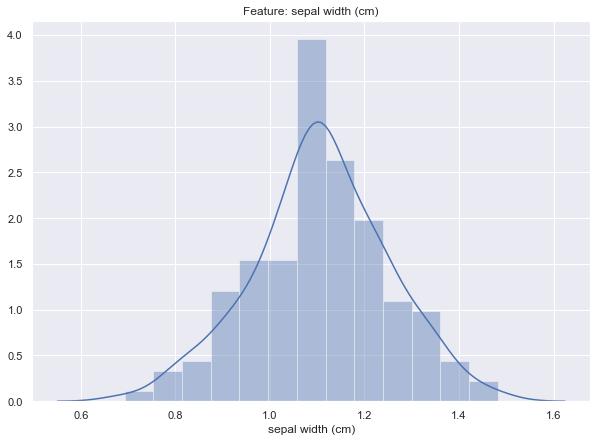

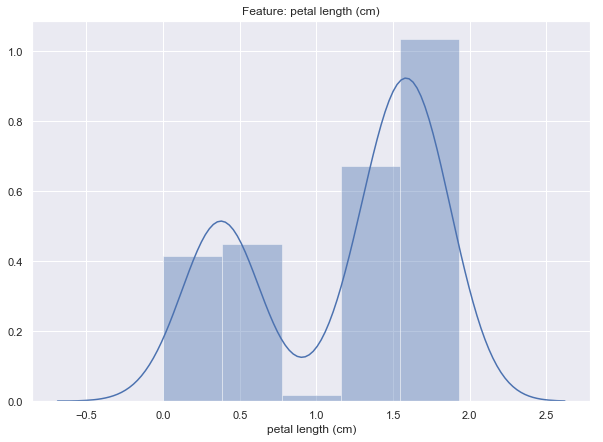

In [ ]:
for feature_name in df_features.numerical_features():

    iris_df[feature_name] = np.log(
        np.where(iris_df[feature_name] < 1e-5,
                 1e-8, iris_df[feature_name]))

    plt.title("Feature: " + feature_name)
    sns.distplot(iris_df[feature_name])
    plt.show()
    plt.close()

#### One hot encode dataframe

In [ ]:
categorical_features = df_features.categorical_features()

iris_df = pd.get_dummies(iris_df,
                         columns=categorical_features,
                         prefix=categorical_features)
iris_df.head()

,sepal width (cm),petal length (cm)
0,1.252763,0.336472
1,1.098612,0.336472
2,1.163151,0.262364
3,1.131402,0.405465
4,1.280934,0.336472


### Scale current data and inspect scaled data

In [ ]:
scaler = StandardScaler()
scaled = scaler.fit_transform(iris_df)

In [ ]:
inspect_feature_matrix(matrix=scaled,
                       feature_names=iris_df.columns)

,Mean,Standard Dev
sepal width (cm),-7.105427e-17,1.0
petal length (cm),9.473903e-17,1.0


#### Apply PCA to scaled matrix and inspect scaled data

In [ ]:
# Create PCA instance: model
pca_model = PCA(random_state=9814)

# Apply the fit_transform method of model to scaled
scaled = pca_model.fit_transform(scaled)

In [ ]:
inspect_feature_matrix(matrix=scaled,
                       feature_names=iris_df.columns)

,Mean,Standard Dev
sepal width (cm),4.736952e-17,1.213491
petal length (cm),-2.368476e-17,0.726251


#### Re-apply scaler after PCA applied

In [ ]:
scaled = scaler.fit_transform(scaled)
inspect_feature_matrix(matrix=scaled,
                       feature_names=iris_df.columns)

,Mean,Standard Dev
sepal width (cm),0.000000e+00,1.0
petal length (cm),-2.368476e-17,1.0


## 5.) Start clustering!!!

### K-Means modeling

#### Store models for dynamic usage for the future.

In [ ]:
cluster_models = dict()

### Find the best k value for KMeans

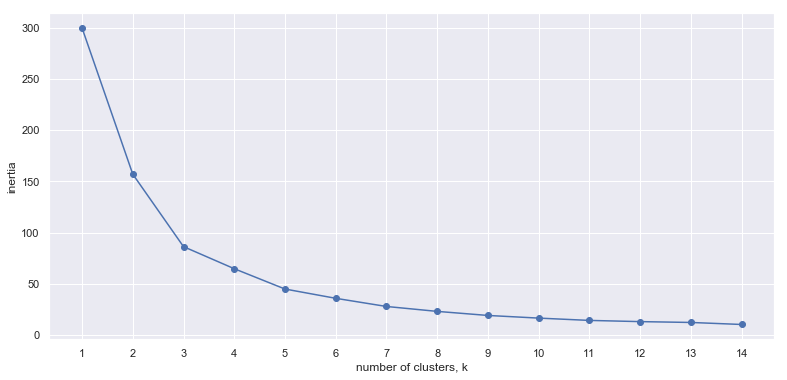

In [ ]:
ks = range(1, 15)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,
                   random_state=10).fit(scaled)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(13, 6))
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
plt.close()

#### "Elbow" k value looks to be about 3.

In [ ]:
cluster_models["kmeans_cluster_3"] = KMeans(n_clusters=3,
                                            random_state=10).fit(scaled)

## Peform Hierarchical clustering to confirm 'k' value

### Graph cluster to confirm proper k values

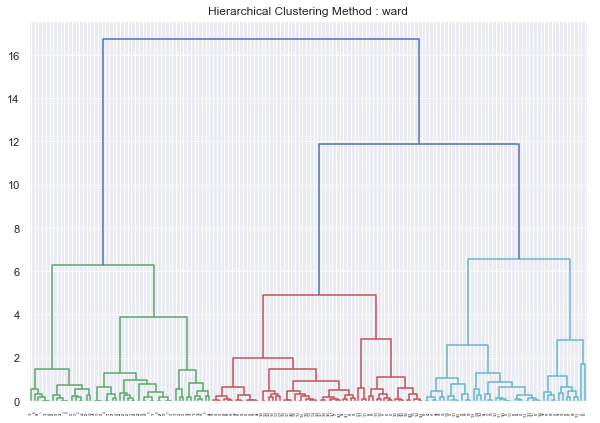

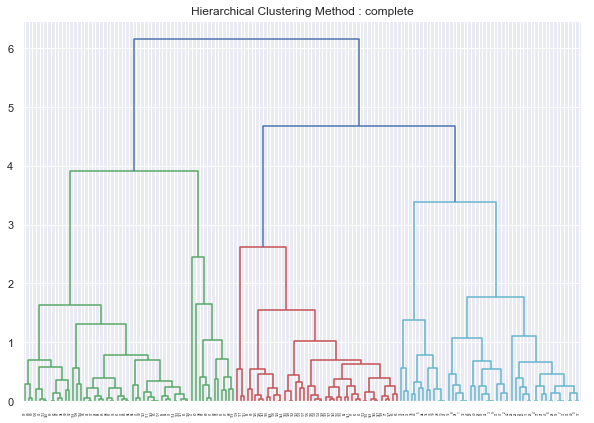

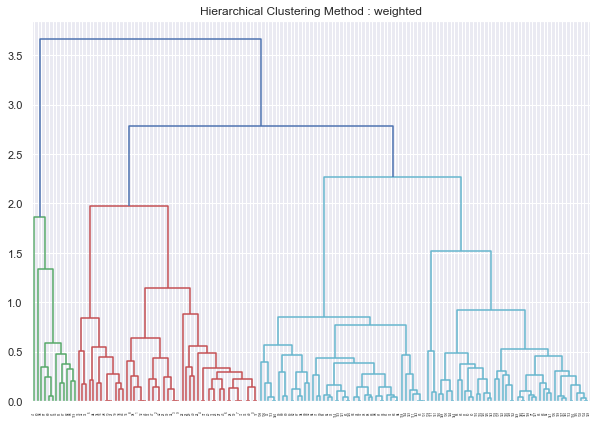

In [ ]:
dendrogram_methods = ["complete",
                      "single",
                      "weighted",
                      "ward",
                      "average",
                      "centroid",
                      "median"]

best_found_methods = ["ward",
                      "complete",
                      "weighted"]

for method in best_found_methods:
    # Calculate the linkage: mergings
    mergings = linkage(scaled, method=method)

    # Plot the dendrogram, using varieties as labels
    dendrogram(mergings,
               labels=list(range(0, len(scaled))),
               leaf_rotation=90,
               leaf_font_size=3,
               )

    plt.title("Hierarchical Clustering Method : " + method)
    plt.show()
    plt.close()

<p>Hierarchical Clustering Method
    shows that there should be around 3 clusters.</p>

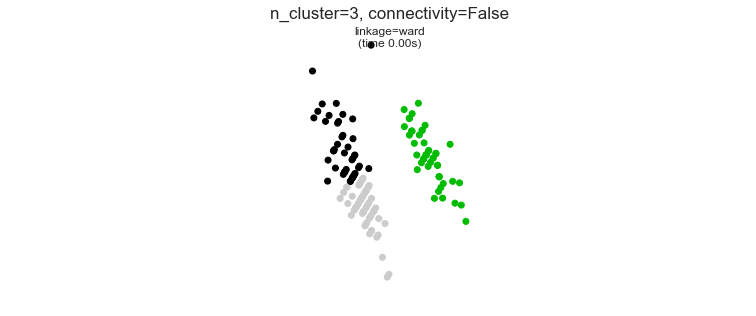

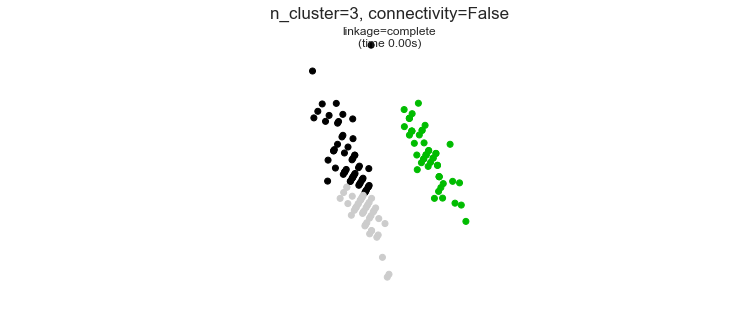

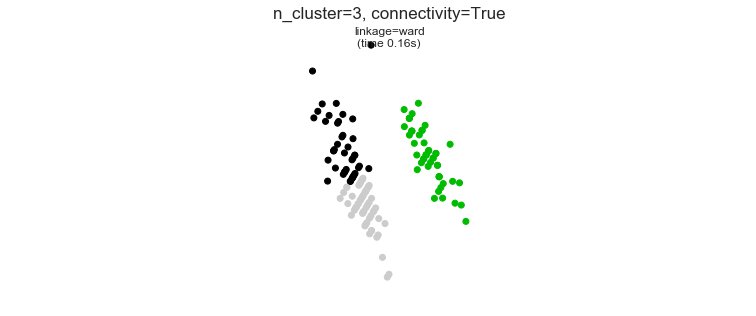

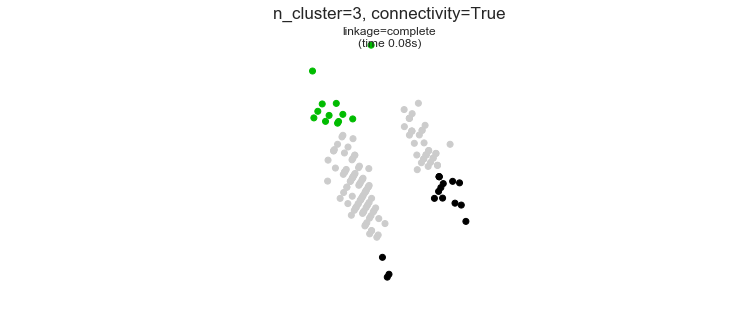

In [ ]:
knn_graph = kneighbors_graph(scaled, 100, include_self=False)
n_clusters = 3
for connectivity in (None, knn_graph):

    for _, linkage in enumerate(["ward", "complete"]):

        plt.figure(figsize=(10, 4))
        model = AgglomerativeClustering(linkage=linkage,
                                        connectivity=connectivity,
                                        n_clusters=n_clusters)
        t0 = time.time()
        model.fit(scaled)
        elapsed_time = time.time() - t0
        plt.scatter(scaled[:, 0], scaled[:, 1], c=model.labels_,
                    cmap=plt.cm.nipy_spectral)
        plt.title('linkage=%s\n(time %.2fs)' % (linkage, elapsed_time),
                  fontdict=dict(verticalalignment='top'))
        plt.axis('equal')
        plt.axis('off')

        plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                            left=0, right=1)
        plt.suptitle('n_cluster=%i, connectivity=%r' %
                     (n_clusters, connectivity is not None), size=17)

        plt.show()
        plt.close()
        cluster_models[
            "AgglomerativeClustering_{0}_cluster{1}_Connectivity{2}".format(
                linkage, n_clusters, connectivity is not None)] = model

#         print(model.labels_)

### Compare models on cluster counts and visualization

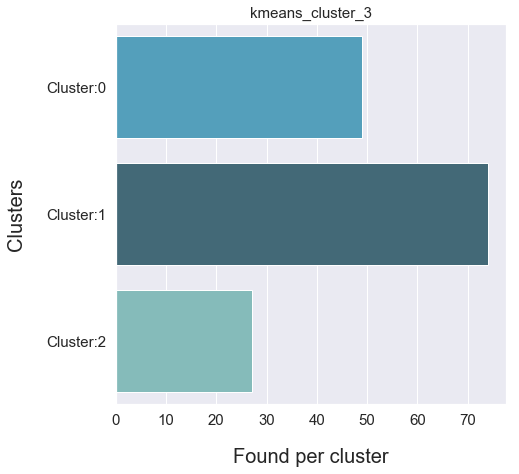

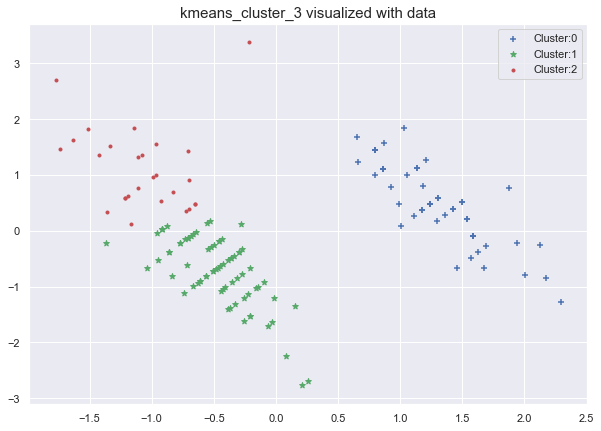

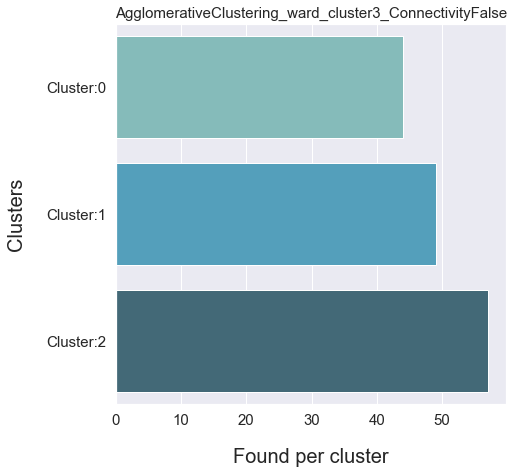

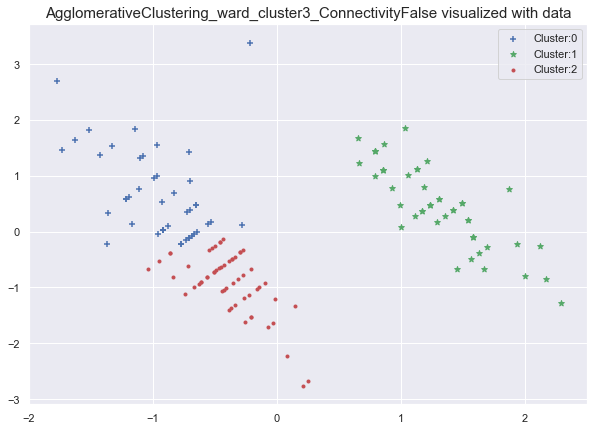

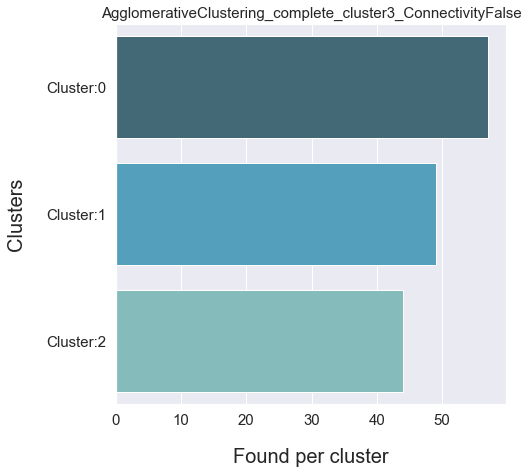

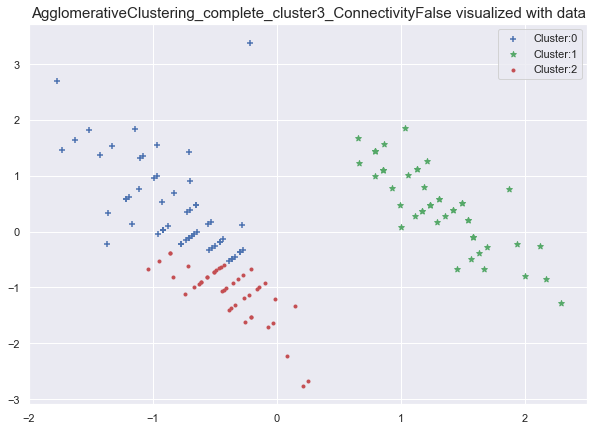

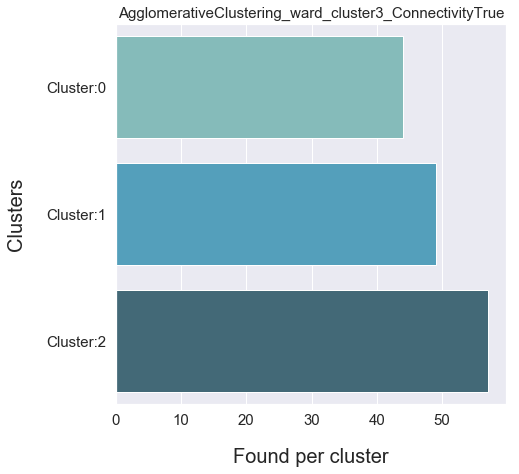

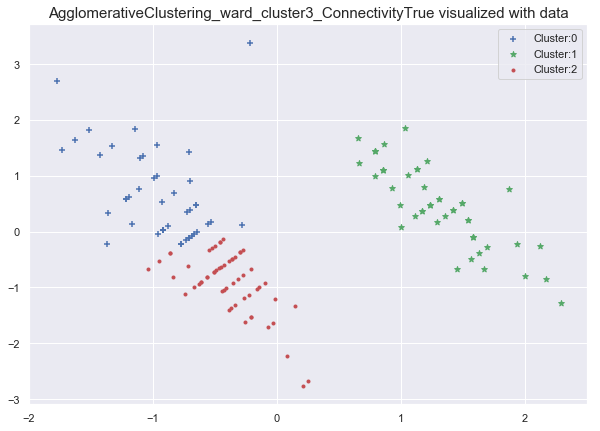

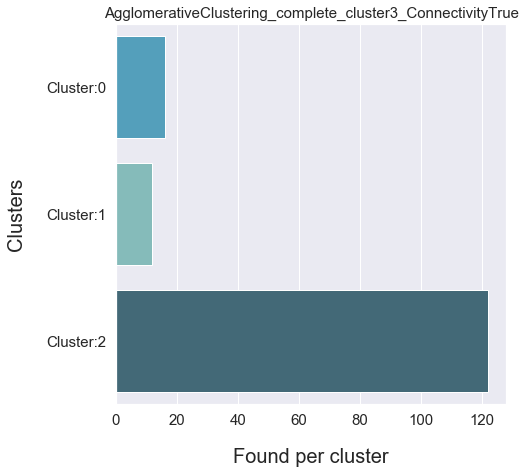

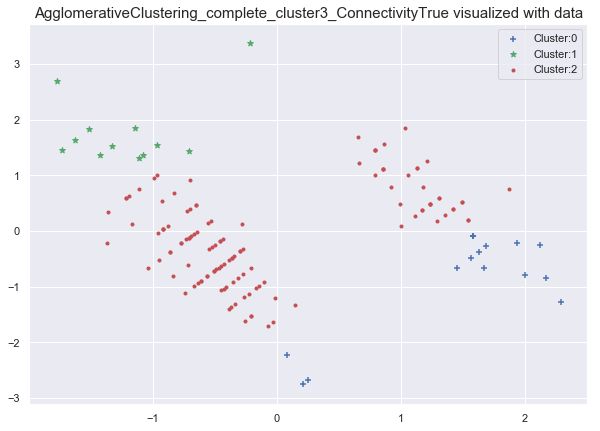

In [ ]:
for model_name, model in cluster_models.items():
    visualize_clusters(model=model,
                       scaled_data=scaled,
                       model_name=model_name)

    # Spacing for next model
    vertical_spacing(8)

<p>Our count plots shows k=3
    for kmeans to have the best
    of the given distributions.
    But <b>ALL</b> of our
    models show the data as not
    being very clusterable with kmeans.</p>

## 6.) Create clustering profiles for best model

### Select some of the "best" models to create profiles for each cluster

In [ ]:
cluster_models.keys()

dict_keys(['kmeans_cluster_3', 'AgglomerativeClustering_ward_cluster3_ConnectivityFalse', 'AgglomerativeClustering_complete_cluster3_ConnectivityFalse', 'AgglomerativeClustering_ward_cluster3_ConnectivityTrue', 'AgglomerativeClustering_complete_cluster3_ConnectivityTrue'])

#### Generate clustered dataframes

In [ ]:
best_model_name = "AgglomerativeClustering_ward_cluster3_ConnectivityFalse"

In [ ]:
# Re-init dataframes with labels
encoded_iris_df["Cluster_Name"] = cluster_models[best_model_name].labels_
clustered_dataframes, shrunken_labeled_df = create_cluster_sub_dfs(
    df=encoded_iris_df, model=cluster_models[best_model_name],
    numerical_features=df_features.numerical_features())

/Users/ericcacciavillani/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/ericcacciavillani/anaconda3/envs/Data_Sci/lib/python3.6/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [ ]:
cluster_profiles = create_cluster_profiles(
    clustered_dataframes=clustered_dataframes,
    shrunken_df=shrunken_labeled_df,
    numerical_features=df_features.numerical_features(),
    show=True)

display(cluster_profiles)

Total found in Cluster:0 is 41


,sepal width (cm),petal length (cm),species
Cluster:0,2.592683,4.42439,1


,sepal width (cm),petal length (cm),species
Mean,2.592683,4.424390,1.341463
Min,2.200000,3.000000,1.000000
Median,2.600000,4.500000,1.000000
Max,2.900000,5.800000,2.000000
Standard Deviation,0.195436,0.659462,0.480091
Variance,0.038195,0.434890,0.230488









Total found in Cluster:1 is 43


,sepal width (cm),petal length (cm),species
Cluster:1,3.411628,1.465116,0


,sepal width (cm),petal length (cm),species
Mean,3.411628,1.465116,0.0
Min,2.900000,1.200000,0.0
Median,3.400000,1.500000,0.0
Max,4.100000,1.700000,0.0
Standard Deviation,0.303322,0.130719,0.0
Variance,0.092004,0.017087,0.0









Total found in Cluster:2 is 53


,sepal width (cm),petal length (cm),species
Cluster:2,3.062264,5.149057,2


,sepal width (cm),petal length (cm),species
Mean,3.062264,5.149057,1.584906
Min,2.800000,4.100000,1.000000
Median,3.000000,5.100000,2.000000
Max,3.400000,6.600000,2.000000
Standard Deviation,0.153456,0.641400,0.497454
Variance,0.023549,0.411393,0.247460









Total points in all shrunken clusters:  137


,petal length (cm),sepal width (cm),species
Cluster:0,4.424390,2.592683,Versicolor
Cluster:1,1.465116,3.411628,Setosa
Cluster:2,5.149057,3.062264,Virginica


## 7.) Visualize kmeans cluster choices with decision tree.

In [ ]:
shrunken_labeled_df.reset_index(inplace=True, drop=True)
display(shrunken_labeled_df.head())
display(shrunken_labeled_df["Cluster_Name"].value_counts())

,Cluster_Name,petal length (cm),sepal width (cm),species
0,0.0,4.0,2.3,1
1,0.0,4.6,2.8,1
2,0.0,4.5,2.8,1
3,0.0,3.3,2.4,1
4,0.0,3.9,2.7,1


2.0    53
1.0    43
0.0    41
Name: Cluster_Name, dtype: int64

### Init naming of clusters before label encode fix

In [ ]:
cluster_names = ["Cluster:" + str(int(cluster_label))
                 for cluster_label in set(
                     shrunken_labeled_df["Cluster_Name"].values)]

### Train test split on model kmeans model choices

In [ ]:
shrunken_labeled_df["species"].value_counts()

1    49
2    45
0    43
Name: species, dtype: int64

In [ ]:
# Made as a joke not to be used for reporting;
display(guess_species_label(shrunken_labeled_df))

{'Versicolor': (0.0, 27), 'Virginica': (2.0, 31), 'Setosa': (1.0, 43)}

In [ ]:
X = np.array(shrunken_labeled_df.drop(
    ["Cluster_Name", "species"], axis=1, inplace=False))
y = np.array(shrunken_labeled_df['Cluster_Name'])

# Split dataframe into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.35,
                                                    random_state=528)

### Hyperparamters for dt

In [ ]:
# Find best parameters for model
param_grid = {
    "max_depth": list(range(1, 5)),
    "min_samples_leaf": list(range(10, 35, 5)),
    "criterion": ["gini", "entropy"],
}

best_param = optimize_model_grid(
    model=DecisionTreeClassifier(),
    X_train=X_train,
    y_train=y_train,
    param_grid=param_grid
)

# Train our decision tree with 'best' parameters
kmeans_tree = DecisionTreeClassifier(**best_param)
kmeans_tree.fit(X_train, y_train)

train_pred = kmeans_tree.predict(X_train)
test_pred = kmeans_tree.predict(X_test)

### Look at confusion matrix for both train and test

### Evaluate Results

In [ ]:
tree_stats_test = pd.DataFrame(
    report_to_dict(
        classification_report(y_test,
                              test_pred))).T
display(tree_stats_test)
print("Test accuracy is {0:2f}".format(accuracy_score(y_test, test_pred)))

In [ ]:
viz = dtreeviz(kmeans_tree,
               X,
               y.astype(np.int64),
               target_name='Cluster Labels',
               feature_names=list(shrunken_labeled_df.drop(
                   ["Cluster_Name", "species"],
                   axis=1,
                   inplace=False).columns),
               class_names=cluster_names)

viz